In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
!pip install transformers datasets accelerate wordcloud

In [5]:
# --- 1. 라이브러리 임포트 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- 2. 기본 설정 ---
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [8]:
# --- 3. 데이터 로드 및 전처리 ---
try:
    df = pd.read_csv('train.csv')
    print("데이터 로드 성공")
except FileNotFoundError:
    print("ERROR: 'train.csv' 파일을 찾을 수 없습니다.")
    df = None

# 이번 분석에서는 'text'와 'target' 컬럼만 사용
df_clean = df[['text', 'target']].copy()

# 간단한 텍스트 클리닝 함수
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # URL 제거
    text = re.sub(r'<.*?>', '', text) # HTML 태그 제거
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) # 알파벳과 공백 외 문자 제거
    text = text.lower() # 소문자 변환
    text = text.strip() # 양 끝 공백 제거
    return text

df_clean['text_cleaned'] = df_clean['text'].apply(clean_text)

데이터 로드 성공


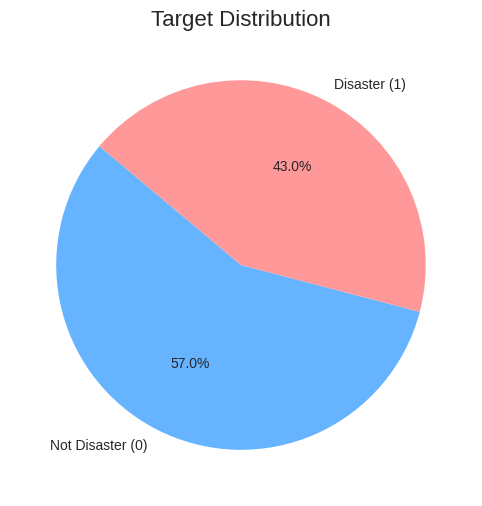

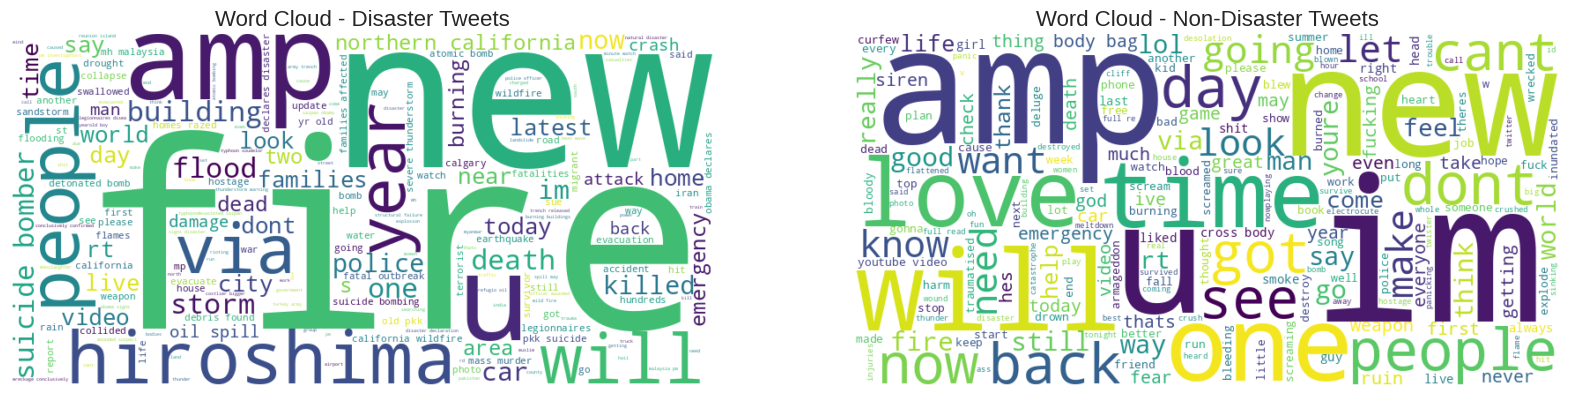

In [10]:
# --- 4. 탐색적 데이터 분석 (EDA) ---
# 타겟 분포 시각화
plt.figure(figsize=(8, 6))
target_counts = df_clean['target'].value_counts()
plt.pie(target_counts, labels=['Not Disaster (0)', 'Disaster (1)'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Target Distribution', fontsize=16)
plt.savefig('target_distribution.png')
plt.show()

# 워드클라우드 생성
disaster_tweets = " ".join(df_clean[df_clean['target']==1]['text_cleaned'])
non_disaster_tweets = " ".join(df_clean[df_clean['target']==0]['text_cleaned'])

wc_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_tweets)
wc_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_tweets)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(wc_disaster, interpolation='bilinear')
axes[0].set_title('Word Cloud - Disaster Tweets', fontsize=16)
axes[0].axis('off')
axes[1].imshow(wc_non_disaster, interpolation='bilinear')
axes[1].set_title('Word Cloud - Non-Disaster Tweets', fontsize=16)
axes[1].axis('off')
plt.savefig('word_clouds.png')
plt.show()

In [11]:
# --- 5. 데이터셋 분할 및 모델 파이프라인 구축 ---
X = df_clean['text_cleaned']
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scikit-learn 파이프라인: TfidfVectorizer와 LogisticRegression을 순차적으로 실행
text_clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42)),
])

In [12]:
# --- 6. 모델 학습 ---
print("\n--- 모델 학습 시작 ---")
text_clf_pipeline.fit(X_train, y_train)
print("--- 모델 학습 완료 ---")


--- 모델 학습 시작 ---
--- 모델 학습 완료 ---



[최종 모델 평가 결과]
정확도: 0.8181


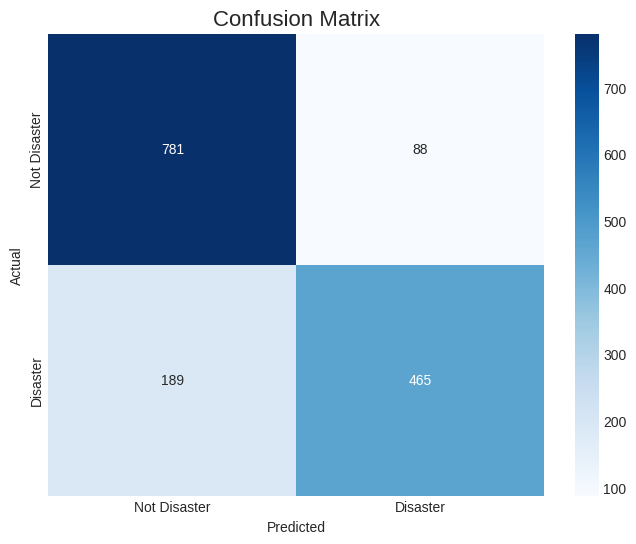


[분류 리포트]
              precision    recall  f1-score   support

Not Disaster       0.81      0.90      0.85       869
    Disaster       0.84      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.82      1523



In [13]:
# --- 7. 모델 평가 ---
predictions = text_clf_pipeline.predict(X_test)

print("\n[최종 모델 평가 결과]")
print(f"정확도: {accuracy_score(y_test, predictions):.4f}")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontsize=16)
plt.savefig('confusion_matrix.png')
plt.show()

print("\n[분류 리포트]")
print(classification_report(y_test, predictions, target_names=['Not Disaster', 'Disaster']))


In [15]:
 # --- 8. 실제 예측 테스트 함수 ---
print("\n--- 실제 예측 테스트 ---")
def predict_disaster(text):
    prediction = text_clf_pipeline.predict([text])[0]
    prediction_proba = text_clf_pipeline.predict_proba([text])[0]

    confidence = prediction_proba[prediction]
    label = "실제 재난 (Disaster)" if prediction == 1 else "재난 아님 (Not Disaster)"

    print(f"입력 문장: '{text}'")
    print(f"예측 결과: {label} (신뢰도: {confidence:.2%})")

predict_disaster("We are safe now, the fire is out")
predict_disaster("Just happened a terrible car crash")
predict_disaster("My stomach is rumbling, I'm so hungry")


--- 실제 예측 테스트 ---
입력 문장: 'We are safe now, the fire is out'
예측 결과: 재난 아님 (Not Disaster) (신뢰도: 52.32%)
입력 문장: 'Just happened a terrible car crash'
예측 결과: 실제 재난 (Disaster) (신뢰도: 56.62%)
입력 문장: 'My stomach is rumbling, I'm so hungry'
예측 결과: 재난 아님 (Not Disaster) (신뢰도: 86.37%)


In [16]:
# --- 1. 라이브러리 임포트 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import torch

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import warnings

In [17]:
# --- 5. 데이터셋 준비 ---
train_df, eval_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['target'])
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [18]:
# --- 6. 토큰화 ---
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples['text_cleaned'], padding='max_length', truncation=True)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
eval_tokenized = eval_dataset.map(tokenize_function, batched=True)

# HuggingFace 모델이 사용할 컬럼만 남기기
train_tokenized = train_tokenized.rename_column("target", "labels")
eval_tokenized = eval_tokenized.rename_column("target", "labels")
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [ ]:
# --- 7. 모델 학습 ---
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"  # wandb 로깅 비활성화
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    compute_metrics=compute_metrics
)

print("\n--- 모델 학습 시작 ---")
trainer.train()
print("--- 모델 학습 완료 ---")

In [ ]:
# --- 8. 모델 평가 ---
eval_results = trainer.evaluate()
print("\n[최종 모델 평가 결과]")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# 혼동 행렬 시각화
predictions = trainer.predict(eval_tokenized)
y_preds = np.argmax(predictions.predictions, axis=-1)
y_true = eval_tokenized['labels']

cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontsize=16)
plt.show()

print("\n[분류 리포트]")
print(classification_report(y_true, y_preds, target_names=['Not Disaster', 'Disaster']))

In [ ]:
# --- 9. 실제 예측 테스트 함수 ---
print("\n--- 실제 예측 테스트 ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_disaster(text):
    cleaned_text = clean_text(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True).to(device)
    model.to(device) # 모델을 올바른 장치로 이동
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = logits.argmax().item()
    confidence = torch.softmax(logits, dim=1).max().item()

    label = "실제 재난 (Disaster)" if predicted_class_id == 1 else "재난 아님 (Not Disaster)"
    print(f"입력 문장: '{text}'")
    print(f"예측 결과: {label} (신뢰도: {confidence:.2%})")

predict_disaster("We are safe now, the fire is out")
predict_disaster("Just happened a terrible car crash")
predict_disaster("My stomach is rumbling, I'm so hungry")